# KDDCup1999

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

## Import datasets

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate"]
label = ["label"]

In [4]:
X_train = pd.read_csv('./data/kddcup/X_train_res.csv', index_col=False)
y_train = pd.read_csv('./data/kddcup/y_train_res.csv', index_col=False)
X_test = pd.read_csv('./data/kddcup/X_test.csv', index_col=False)
y_test = pd.read_csv('./data/kddcup/y_test.csv', index_col=False)

In [5]:
y_train.value_counts()

label
0        2748096
1        2748096
Name: count, dtype: int64

Labels:  
0 = normal  
1 = attack

In [14]:
X_train.shape, X_test.shape

((5496192, 41), (1469530, 41))

In [15]:
# Function to print classification reports and plot confusion matrix and ROC curve
def print_reports(clf, X_test, y_test, y_pred, classes, title):
    print(title)
    # print classification report
    print(classification_report(y_test, y_pred))
    
    print()
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print()
    
    # plot ROC curve
    roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## Model training
### Stochastic Gradient Descent

In [28]:
%%time
sgd_clf = SGDClassifier(max_iter=1000)
sgd_clf.fit(X_train, y_train.values.ravel())
sgd_pred = sgd_clf.predict(X_test)

CPU times: user 34 s, sys: 1.79 s, total: 35.8 s
Wall time: 35.5 s


SGD Classifier Confusion Matrix
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    291976
           1       1.00      0.95      0.98   1177554

    accuracy                           0.96   1469530
   macro avg       0.92      0.98      0.95   1469530
weighted avg       0.97      0.96      0.96   1469530




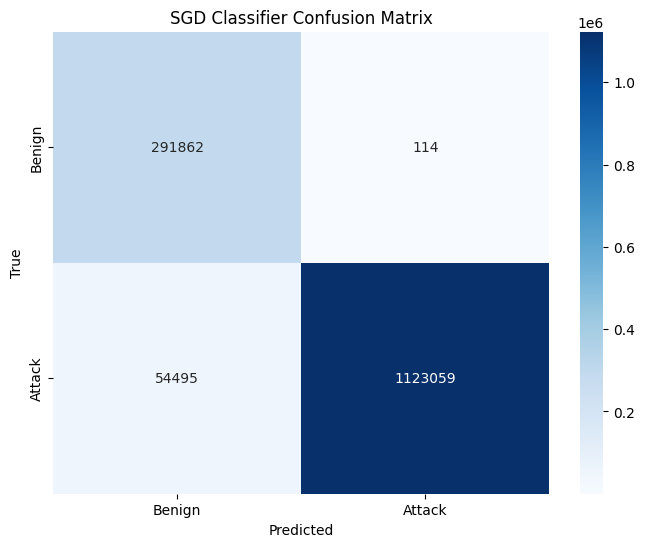

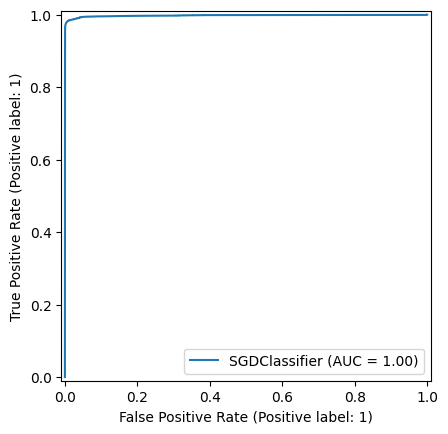

In [29]:
print_reports(sgd_clf, X_test, y_test, sgd_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix')

### Feature Selection